In [1]:
import os
import numpy as np
import pandas as pd
from scipy.special import softmax
from scipy.special import expit
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp


from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.colors as colors
import matplotlib.cm as cm



from read_dataset_for_constraint import switch_dataset

from utils import plot_hyperrectangles, plot_pdfR

np.set_printoptions(precision=5)
tfd = tfp.distributions
np.random.seed(111)
tf.random.set_seed(111)



In [2]:

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))


TensorFlow version: 2.1.0
Eager execution: True


In [96]:
dataset_name = "wdbc"
type_eta = "eta_variant"
if_pca = True

X_train, y_train, X_val, y_val, X_test, y_test, y_train_onehot, y_val_onehot, y_test_onehot, scaler, color_map = \
    switch_dataset(dataset_name)(if_PCA = if_pca)

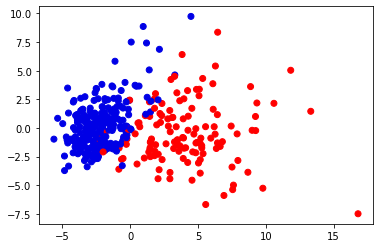

In [97]:
plt.scatter(X_train[:,0], X_train[:,1], color=[color_map[i] for i in y_train])

#plt.scatter(X_test[0],X_test[:,1], marker='^', color=[color_map[i] for i in y_test])
plt.show()

In [110]:
#M = X_train.shape[1]

number_components = 4

save_loss = []
#np.random.seed(903604963)
#np.random.seed(1595417368)
#seed = np.random.seed(159541736)
seed = np.random.seed(112)

np.random.seed(seed)
tf.random.set_seed(seed)


class SoftTruncatedGaussianMixture(tf.Module):

    def __init__(self, number_components, val_min, val_max, seed = 111):
        
        super(SoftTruncatedGaussianMixture, self).__init__()
        np.random.seed(seed)
        tf.random.set_seed(seed)
        
        self.eta =  tf.Variable(0., trainable=False) 
        self.number_components = number_components
        self.stable = tf.constant(np.finfo(np.float32).eps)
        
        self.M = len(val_min)



        
        self.mu = tf.Variable(np.random.randn(self.number_components, self.M), dtype = tf.float32,
                                              name = "mu")
        np.random.seed(seed)
        self.lower = tf.Variable(np.random.randn(self.number_components, self.M), dtype = tf.float32,
                                                name = "lower")
        np.random.seed(seed)
        self.upper = tf.Variable(np.random.randn(self.number_components, self.M), dtype = tf.float32,
                                                 name = "upper")
        self.sigma = tf.Variable([[0.2 for j in range(self.M)] for i in range(number_components)], 
                                     dtype = tf.float32, name = "sigma")
#         self.logits_k = tf.Variable(np.random.randn(number_components), 
#                                         dtype = tf.float32,  name= "logits")

        
       
        #self.toto = tf.Variable(0.5)*
        self.initialise_variables(val_min_in = val_min, val_max_in = val_max, seed = seed) #, 
                                 # way = "toy_example_case")        
    
    def initialise_variables(self, val_min_in, val_max_in, way = "random", seed = 111, X_train = None, k = 0):
        np.random.seed(seed)
        tf.random.set_seed(seed)
        self.logits_k = tf.Variable(np.random.randn(number_components), 
                                        dtype = tf.float32,  name= "logits")
        if way == "random":
            val = np.random.uniform(low= val_min_in, high = val_max_in, size = (self.M, 
                                                                                self.number_components, self.M))
            l = np.min(val, axis = 0).astype(np.float32)
            u = np.max(val, axis = 0).astype(np.float32)
            self.lower.assign(l)

            self.upper.assign(u)

            self.mu.assign([(1./2)*(l[i,:] + u[i,:]) for i in range(number_components)])


            self.sigma.assign([[0.2 for j in range(self.M)] for i in range(number_components)])
            
        if way == "toy_example_case":
            #print("toto")
            self.mu.assign([[-1.5 , 0], [1.5, 0]])
        
            self.lower.assign([[-3.0, -3], [0, -3]])
        
            self.upper.assign([[0, 3.0], [3, 3]])
            self.sigma.assign([[0.2 for j in range(M)] for i in range(number_components)])
    
    def gmm_initialisation(self, X_train):
        prob_line = 3.0
        
        gmm = GaussianMixture(n_components= self.number_components, covariance_type="diag")
        gmm.fit(X_train)
#         sigma_prod = - np.log((2*np.pi/prob_line)*np.prod(gmm.covariances_, axis = 1))

#         low = gmm.means_ - np.sqrt(2 * sigma_prod )* gmm.covariances_
        
#         upp = gmm.means_ + np.sqrt(2 * sigma_prod )* gmm.covariances_
        low = gmm.means_ - np.sqrt(gmm.covariances_)
        upp = gmm.means_ + 0.4*np.sqrt(gmm.covariances_)
        
        self.lower.assign(low.astype(np.float32))
        self.upper.assign(upp.astype(np.float32))
        self.mu.assign(gmm.means_.astype(np.float32))
        
        self.sigma.assign(gmm.covariances_.astype(np.float32))
         
        
    def noverlap():
        

        centers = (1./2)*(model.lower + model.upper)
        radii = tf.norm(model.upper - model.lower , axis= 1, keepdims=True)

        r = tf.reduce_sum(centers*centers, 1)

            # Turning r into vector
        r = tf.reshape(r, [-1, 1])
        D = r - 2*tf.matmul(centers, tf.transpose(centers)) + tf.transpose(r)
        

        penalty = tf.linalg.band_part((tf.transpose(radii) + radii)/(D + tf.eye(num_rows = D.shape[0])) 
                                       , num_lower= 0, num_upper = 1)

            
            
        return tf.reduce_sum(penalty - tf.linalg.tensor_diag(tf.linalg.diag_part(penalty)))           
    
    
    @tf.function
    def normalizing_constant(self, way = "independent"):
        if way == "independent":
            # Reconstructing the independent variables
            dict1 = ({(k, d): tfd.Normal(loc = self.mu[k,d], 
                 scale = np.finfo(np.float32).eps + tf.nn.softplus(self.sigma[k,d])) 
                 for d in range(self.M) for k in range(self.number_components)} )
            
            #Return \int_{lower}^{upper} Normal(\mu, \Sigma) dx1 ... dxn   
            return tf.reduce_prod(tf.stack([[dict1[(k,d)].cdf(self.upper[k,d]) - dict1[(k,d)].cdf(self.lower[k,
                            d])+ self.stable for d in range(self.M) ] for k in range(self.number_components)]),
                                axis = 1, keepdims = True) + self.stable 

        
    @tf.function
    def logistic (self, x):

        return tf.sigmoid(tf.math.multiply(self.eta,x))
    
    def compute_pdf(self, x):
        dist = tfd.Mixture(
          cat = tfp.distributions.Categorical(logits = self.logits_k),
        components = [tfd.Independent(tfd.Normal(loc = self.mu[i,:], 
                                              scale = np.finfo(np.float32).eps + tf.nn.softplus(self.sigma[i,:])),
                              reinterpreted_batch_ndims=1) for i in range(self.number_components)
          ])
        
        p_x_given_k = ( tf.transpose(tf.stack([dist.components[i].prob(x)  
                        for i in range(self.number_components)])/self.normalizing_constant()) )
        p_more_lower_given_x = tf.stack([x-tf.expand_dims(self.lower[i,:], 
                                                          axis=0) for i in range(self.number_components)])
        #Shape [K x N x M]
        p_less_upper_given_x = tf.stack([tf.expand_dims(self.upper[i,:], 
                                                        axis=0) - x for i in range(self.number_components)])

        #         tf.print(self.eta*tf.reduce_mean(tf.multiply(tf.expand_dims(tf.transpose(responsabilities),
#                                                                    -1), 
#                                                      tf.math.log(self.logistic(p_less_upper_given_x))), 
#                                                      axis =1))
        
        p_more_lower_given_x = tf.transpose(tf.reduce_prod(self.logistic(p_more_lower_given_x), axis = -1))
        
        p_less_upper_given_x = tf.transpose(tf.reduce_prod(self.logistic(p_less_upper_given_x), axis = -1))
        
        p_x_given_k_trunc = tf.multiply(p_x_given_k,p_less_upper_given_x)
        

        p_x_given_k_trunc = tf.multiply(p_x_given_k_trunc,p_more_lower_given_x)
        
        return tf.math.multiply( tf.expand_dims(tf.stack(dist._cat_probs(log_probs=False)), axis = 0),
                                              p_x_given_k_trunc)
        
        
        
    @tf.function
    def __call__(self, x, responsabilities):

        dist = tfd.Mixture(
          cat = tfp.distributions.Categorical(logits = self.logits_k),
        components = [tfd.Independent(tfd.Normal(loc = self.mu[i,:], 
                                              scale = np.finfo(np.float32).eps + tf.nn.softplus(self.sigma[i,:])),
                              reinterpreted_batch_ndims=1) for i in range(self.number_components)
          ])
        
        
        def debugging_gradients():
            #Debugging gradients
            dict1 = {(i,j): tfd.Normal(loc = self.mu[i,j], 
                     scale = np.finfo(np.float32).eps + tf.nn.softplus(self.sigma[i,
                    j])) for i in range(self.number_components) for j in range(self.M)}

            #Shape [K x M]
            aug_ment_less = ( ( tf.stack([[dict1[(k,d)].prob(self.lower[k,d])
                            /( dict1[(k,d)].cdf(self.upper[k,d]) - dict1[(k,d)].cdf(self.lower[k,d]) + self.stable) 
                            for d in range(self.M) ]  
                         for k in range(self.number_components)]) ) )
            aug_ment_up = ( ( tf.stack([[ dict1[(k,d)].prob(self.upper[k,d])
                            /( dict1[(k,d)].cdf(self.upper[k,d]) - dict1[(k,d)].cdf(self.lower[k,d]) + self.stable) 
                            for d in range(self.M) ] 
                         for k in range(self.number_components)]) ) )


    #         tf.print(- tf.reduce_sum(tf.math.log([[dict1[(k,d)].cdf(self.upper[k,d]) - \
    #                                                dict1[(k,d)].cdf(self.lower[k,d]) + self.stable \
    #                                                 for d in range(M) ] \
    #                      for k in range(self.number_components)]), axis = 1, keepdims = True)) 
            tf.print(aug_ment_less)
            tf.print(aug_ment_up)
            tf.print(aug_ment_less - aug_ment_up)
            toto = (tf.expand_dims(x, axis = 1) - tf.expand_dims(self.mu,
                                axis = 0))/(tf.expand_dims( tf.square(tf.nn.softplus(self.sigma) + self.stable),
                                                        axis = 0))
            tf.print("Mu ",  tf.reduce_mean(( - toto + tf.expand_dims(aug_ment_less - aug_ment_up, 
                                    axis = 0)) *  f.expand_dims(responsabilities, axis = -1),
                                            axis = 0))
#             tf.print(tf.reduce_mean(tf.multiply(tf.expand_dims(tf.transpose(responsabilities),
#                                                                axis = -1), 
#                                         self.eta * (1 - self.logistic(p_more_lower_given_x)) + aug_ment_less), 
#                                                          axis = 1))



        pik = tf.stack(dist._cat_probs(log_probs=False))
        
       
        #Put to shape [M x K]
        pik = tf.expand_dims(pik, axis=0)
    
        #Shape [K x N x M]
        p_more_lower_given_x = tf.stack([x-tf.expand_dims(self.lower[i,:], 
                                                          axis=0) for i in range(self.number_components)])
        #Shape [K x N x M]
        p_less_upper_given_x = tf.stack([tf.expand_dims(self.upper[i,:], 
                                                        axis=0) - x for i in range(self.number_components)])

        #         tf.print(self.eta*tf.reduce_mean(tf.multiply(tf.expand_dims(tf.transpose(responsabilities),
#                                                                    -1), 
#                                                      tf.math.log(self.logistic(p_less_upper_given_x))), 
#                                                      axis =1))
        
        p_more_lower_given_x = tf.transpose(tf.reduce_prod(self.logistic(p_more_lower_given_x), axis = -1))
        
        p_less_upper_given_x = tf.transpose(tf.reduce_prod(self.logistic(p_less_upper_given_x), axis = -1))
        
        
        

        #debugging_gradients()

        
        
       
        #tf.print(self.eta*tf.reduce_mean(tf.multiply(responsabilities, p_less_upper_given_x), axis =1))
    
        p_x_given_k =  tf.math.multiply(pik,                                 
                        tf.transpose(tf.stack([dist.components[i].prob(x)  for i in range(self.number_components)])/self.normalizing_constant())) 

        
        p_x_given_k_trunc = tf.multiply(p_x_given_k,p_less_upper_given_x)
        

        p_x_given_k_trunc = tf.multiply(p_x_given_k_trunc,p_more_lower_given_x)
        #------ Test        
#         return  - tf.reduce_mean( tf.reduce_sum(tf.multiply(responsabilities, 
#                          tf.math.log(tf.clip_by_value(p_x_given_k_bis, 1e-10, 8.))), axis = 1))
        #return - tf.reduce_sum(tf.math.log(self.normalizing_constant()))
        #------ Fin Test
        return  - tf.reduce_mean( tf.reduce_sum(tf.multiply(responsabilities, 
                        tf.math.log(tf.clip_by_value(p_x_given_k_trunc, 1e-10, 8.))), axis = 1)) #- 0.1*tf.reduce_sum(regul_mu) # + 0.01* noverlap() 
    

    
model = SoftTruncatedGaussianMixture(number_components = number_components, val_max = np.amax(X_train, axis = 0), 
                                     val_min = np.amin(X_train, axis = 0), seed= seed)
model.gmm_initialisation(X_train)

# plt.scatter(X_train[:,0], X_train[:,1], color=[color_map[i] for i in y_train])

# plt.scatter(*model.mu.numpy().T, marker='^')
# plt.show()
#print(model.trainable_variables)

optimizer = tf.optimizers.Adam(lr = 0.001)

loss = 0.0

@tf.function
def train_step(data, responsabilities, eta):
    model.eta.assign(eta)
    with tf.GradientTape() as tape:
        current_loss = model(data, responsabilities)
    gradients = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    
    return current_loss, responsabilities, gradients

def compute_responsabilities(x, model):
    def logistic(eta,x):
        
        return expit(eta*x)
    
    dist1 = tfd.Mixture(
    cat = tfp.distributions.Categorical(logits = model.logits_k),
          components = [ 
              tfd.Independent(tfd.Normal(loc = model.mu[i,:],
                                         scale = np.finfo(np.float32).eps + tf.nn.softplus(model.sigma[i,:])),
                              reinterpreted_batch_ndims = 1) for i in range(model.number_components)
          ])
        
        
    pi = dist1._cat_probs(log_probs=False)
    pi = [pro.numpy() for pro in pi]
        
    pi = np.expand_dims(pi, axis=0)
    
    
    
    p_more_lower_given_x = np.stack([x-np.expand_dims(model.lower[i,:].numpy(), 
                                                      axis=0) for i in range(model.number_components)])


    p_more_lower_given_x = np.transpose(np.prod(logistic(model.eta.numpy(),p_more_lower_given_x), axis = -1))
    
    p_less_upper_given_x = np.stack([np.expand_dims(model.upper[i,:].numpy(), 
                                                    axis=0) - x for i in range(model.number_components)])
    #print(p_less_upper_given_x)
    p_less_upper_given_x = np.transpose(np.prod(logistic(model.eta.numpy(),p_less_upper_given_x), axis = -1))

    
    
    
    p_x_given_k =( np.multiply(pi,
                    np.transpose(np.stack([dist1.components[i].prob(x).numpy()
                                    for i in range(model.number_components)]) 
                                 / model.normalizing_constant().numpy())) )
#     print(model.lower)
#     print(model.upper)
    
#     print(p_x_given_k[0:10])
#     print(p_less_upper_given_x[0:10])
#     print(x[0:10])
        
    p_x_given_k_trunc = np.multiply(p_x_given_k,p_less_upper_given_x)
    

      
    p_x_given_k_trunc = np.multiply(p_x_given_k_trunc,p_more_lower_given_x)
    

    responsabilities = np.clip(p_x_given_k_trunc, 1e-8, 8)
    
    #print(responsabilities)

    responsabilities = softmax(np.log(responsabilities), axis = 1)
    
    
    return responsabilities

lloss= {}
eta = 20
        
for i in range(100):
    #Expectation step
    directory = f"images_sTMVN/datasets/{dataset_name}/{type_eta}"
        
    if type_eta == "eta_constant":
            directory = f"{directory}/{value}_{eta}"
    else:
        eta = (0.5)*np.sqrt(i) + 10
        
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = f"{directory}/image" 
    #print(probs_x_given_k.shape)
    responsabilities = compute_responsabilities(X_train, model)
    plot_hyperrectangles(X_train, y_train, 0, 1, model.lower.numpy(), model.upper.numpy(), 
                         nb_hyperrectangles = model.number_components, 
                         file_name = f"{filename}_rectangles_{i}.png", 
                         color_map = color_map, mu = model.mu.numpy())
    plot_pdfR(X_train[:,0], X_train[:,1], f"{filename}_density_{i}.png", model, color_map)
    #print(responsabilities)
    #print(pi, probs_x_given_k)
    
    #Maximization
    lloss[i] = []

    for j in range(100):
        
        loss, resp, grad = train_step(data = X_train, responsabilities = responsabilities, eta = eta)
        #print(model.trainable_variables)
        #print(grad)
        loss, resp = loss.numpy(), resp.numpy() 
        lloss[i].append(loss)
        #print(grad)
    save_loss.append(loss)
    #f = model.compute_pdf(X_train)
    #plot_pdf(X_train[:,0], X_train[:,1], f, f"images_sTMVN/image_{i}")

<Figure size 432x288 with 0 Axes>

In [82]:
model.sigma

<tf.Variable 'sigma:0' shape=(2, 30) dtype=float32, numpy=
array([[0.25594, 0.88772, 0.23457, 0.14995, 0.89685, 0.27101, 0.12916,
        0.1396 , 0.7737 , 0.59563, 0.14451, 1.22161, 0.12805, 0.03193,
        0.84337, 0.34434, 0.31724, 0.47961, 0.6516 , 0.34536, 0.17201,
        0.88134, 0.16092, 0.08417, 0.80861, 0.23795, 0.24725, 0.29227,
        0.50867, 0.31513],
       [1.04162, 0.87111, 1.00447, 1.24469, 0.78978, 0.88952, 0.8172 ,
        0.76971, 0.94998, 1.63899, 1.48036, 0.59406, 1.4992 , 1.81133,
        1.27368, 1.30818, 1.47184, 0.99384, 1.598  , 1.75721, 1.05863,
        0.85586, 1.02137, 1.33951, 0.92202, 1.10576, 0.8824 , 0.58963,
        1.39895, 1.63282]], dtype=float32)>

In [83]:
gmm = GaussianMixture().fit(X_train)

In [86]:
gmm.covariances_.shape

(1, 30, 30)

In [64]:
model.upper

<tf.Variable 'upper:0' shape=(2, 2) dtype=float32, numpy=
array([[ 1.61537, -0.02308],
       [ 1.98072,  1.67   ]], dtype=float32)>

In [65]:
model.eta

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=20.0>

In [7]:
model.lower

<tf.Variable 'lower:0' shape=(2, 2) dtype=float32, numpy=
array([[ 2.2911 , -0.61729],
       [-2.70448, -0.90566]], dtype=float32)>

In [8]:
model.upper

<tf.Variable 'upper:0' shape=(2, 2) dtype=float32, numpy=
array([[ 2.74613, -0.71572],
       [-2.77855, -0.38273]], dtype=float32)>

In [37]:
x = X_train[:, 0]
y = X_train[:, 1]
# Define the borders
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY

# Create meshgrid
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

print(xx.shape)
values = np.vstack([x, y])
predictions = model.compute_pdf(positions.T).numpy()
pred1 = predictions[:,0]
pred2 = predictions[:,1]
f1 = np.reshape(pred1.T, xx.shape)
f2 = np.reshape(pred2.T, xx.shape)


(100, 100)


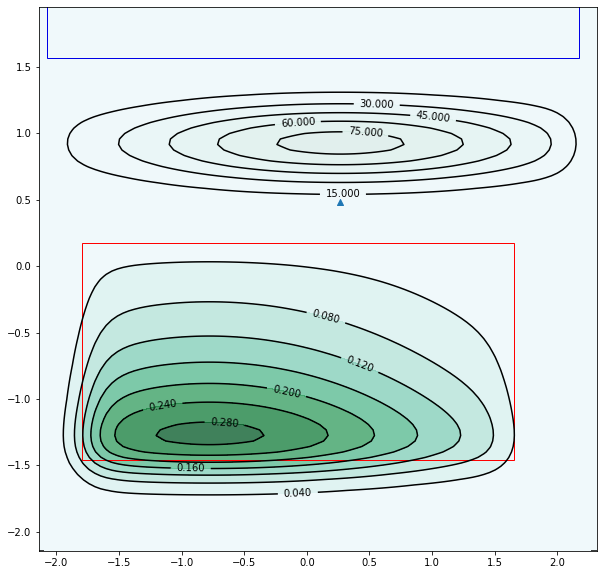

In [38]:
alpha = softmax(model.logits_k.numpy())
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
cfset = ax.contourf(xx, yy, f1, cmap='BuGn', alpha = alpha[0])
# ax.imshow(np.rot90(f1), cmap='BuGn', extent=[xmin, xmax, ymin, ymax])
cset1 = ax.contour(xx, yy, f1, colors='k')
ax.clabel(cset1, inline=1, fontsize=10)

cfset = ax.contourf(xx, yy, f2, cmap='BuGn', alpha = alpha[1])
cset = ax.contour(xx, yy, f2, colors='k')
ax.clabel(cset, inline=1, fontsize=10)
currentAxis = plt.gca()
currentAxis = plt.gca()
x_axis = 0
y_axis = 1
for i in range(2):
    low = model.lower.numpy()[i]
    upp = model.upper.numpy()[i]
    currentAxis.add_patch(Rectangle((low[x_axis], low[y_axis]), upp[x_axis]-low[x_axis], upp[y_axis]-low[y_axis], fill=None,
                                    edgecolor=color_map[i], alpha=1))
    plt.scatter(*model.mu.numpy()[i,[x_axis, y_axis]], marker='^')

#plt.scatter(X_train[:,x_axis], X_train[:,y_axis], color=[color_map[i] for i in y_train])
#ax.imshow(np.rot90(f2), cmap='BuGn', extent=[xmin, xmax, ymin, ymax])


In [41]:
model.compute_pdf(X_train).numpy()

array([[2.15482e-15, 2.05760e-01],
       [6.51050e+01, 5.76164e-06],
       [4.52911e+01, 2.17391e-05],
       [4.72271e-10, 9.54920e-02],
       [8.08745e+00, 1.83341e-08],
       [1.49414e-05, 3.30812e-02],
       [6.83564e-34, 3.31984e-02],
       [6.09735e+01, 1.33263e-06],
       [3.18223e+00, 1.10864e-05],
       [2.32406e-15, 4.99370e-02],
       [2.25999e-11, 5.89202e-02],
       [2.26358e-25, 2.41767e-01],
       [6.51305e+01, 8.98243e-06],
       [6.66755e+00, 1.19248e-04],
       [8.13521e+00, 3.08210e-04],
       [7.50130e-20, 1.57578e-01],
       [3.84439e+01, 8.98986e-05],
       [2.64549e-35, 1.32903e-02],
       [1.30015e-10, 1.35926e-01],
       [3.58000e+01, 9.77832e-07],
       [2.35240e+01, 1.13022e-04],
       [5.73079e+00, 9.14734e-04],
       [3.25035e-02, 2.77493e-02],
       [1.75051e-14, 1.00827e-01],
       [5.31741e+00, 2.90189e-04],
       [2.87296e+01, 3.89819e-07],
       [1.66940e-11, 1.48312e-01],
       [2.76230e-01, 1.04299e-09],
       [2.36312e-14,

In [12]:
softmax(model.logits_k.numpy())

array([0.85634, 0.14366], dtype=float32)

In [50]:
x = [[0,1]]

In [51]:
dist = tfd.Mixture(
          cat = tfp.distributions.Categorical(logits = model.logits_k),
        components = [tfd.Independent(tfd.Normal(loc = model.mu[i,:], 
                                              scale = np.finfo(np.float32).eps + tf.nn.softplus(model.sigma[i,:])),
                              reinterpreted_batch_ndims=1) for i in range(model.number_components)
          ])
        
p_x_given_k = tf.transpose(tf.stack([dist.components[i].prob(x)  \
                        for i in range(model.number_components)])/model.normalizing_constant())

p_x_given_k

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[8.74481e+04, 1.01888e-02]], dtype=float32)>

In [61]:
p_more_lower_given_x = tf.stack([x-tf.expand_dims(model.lower[i,:], 
                                                          axis=0) for i in range(model.number_components)])
        #Shape [K x N x M]
p_less_upper_given_x = tf.stack([tf.expand_dims(model.upper[i,:], 
                                                        axis=0) - x for i in range(model.number_components)])

        #         tf.print(self.eta*tf.reduce_mean(tf.multiply(tf.expand_dims(tf.transpose(responsabilities),
#                                                                    -1), 
#                                                      tf.math.log(self.logistic(p_less_upper_given_x))), 
#                                                      axis =1))
      
p_more_lower_given_x = tf.transpose(tf.reduce_prod(model.logistic(p_more_lower_given_x), axis = -1))
        
p_less_upper_given_x = tf.transpose(tf.reduce_prod(model.logistic(p_less_upper_given_x), axis = -1))
print(p_more_lower_given_x)
print(p_less_upper_given_x)
print(p_x_given_k)
p_x_given_k_trunc = tf.multiply(p_x_given_k,p_less_upper_given_x)
        

p_x_given_k_trunc = tf.multiply(p_x_given_k_trunc,p_more_lower_given_x)
        
tf.math.multiply( tf.expand_dims(tf.stack(dist._cat_probs(log_probs=False)), axis = 0),
                                              p_x_given_k_trunc)

tf.Tensor([[0.00334 1.     ]], shape=(1, 2), dtype=float32)
tf.Tensor([[9.99999e-01 2.58335e-04]], shape=(1, 2), dtype=float32)
tf.Tensor([[8.74481e+04 1.01888e-02]], shape=(1, 2), dtype=float32)


<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[7.49665e+01, 1.95659e-06]], dtype=float32)>

In [13]:
prob_line= 2
sigma_prod = - np.log((2*np.pi/prob_line)*np.prod(gmm.covariances_, axis = 1))

lower = gmm.means_ - np.sqrt(2 * sigma_prod )* gmm.covariances_
upper = gmm.means_ + np.sqrt(2 * sigma_prod )* gmm.covariances_
plot_hyperrectangles(X_train, y_train, 0, 1, lower, upper, 
                         nb_hyperrectangles = 2, file_name = f"images_sTMVN/toto.png", 
                         color_map = color_map, mu = gmm.means_)

NameError: name 'gmm' is not defined

In [ ]:
sigma_prod = - np.log(np.prod(np.pi*gmm.covariances_)))

In [30]:
model.lower

<tf.Variable 'lower:0' shape=(2, 2) dtype=float32, numpy=
array([[-1.99291,  1.57379],
       [-1.95009, -0.23421]], dtype=float32)>

In [59]:
model.upper

<tf.Variable 'upper:0' shape=(2, 2) dtype=float32, numpy=
array([[2.17588, 2.3765 ],
       [1.65496, 0.1739 ]], dtype=float32)>

In [58]:
tf.sigmoid(tf.math.multiply(model.eta,model.upper - x))

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1.00000e+00, 9.99999e-01],
       [1.00000e+00, 2.58335e-04]], dtype=float32)>

In [ ]:
np.pi*np.prod(np.sqrt(gmm.covariances_))

In [ ]:
sigma_prod = - np.log(np.pi*np.prod(np.sqrt(gmm.covariances_)))
sigma_prod

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
cfset = ax.contourf(xx, yy, f2, cmap='Purples', alpha = 0.5)
cset = ax.contour(xx, yy, f2, colors='k')
#ax.imshow(np.rot90(f2), cmap='viridis', extent=[xmin, xmax, ymin, ymax])
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.title('2D Gaussian Kernel density estimation')

In [ ]:
dist = tfd.Mixture(
          cat = tfp.distributions.Categorical(logits = model.logits_k),
        components = [tfd.Independent(tfd.Normal(loc = self.mu[i,:], 
                                              scale = np.finfo(np.float32).eps + tf.nn.softplus(self.sigma[i,:])),
                              reinterpreted_batch_ndims=1) for i in range(self.number_components)
          ])
        
p_x_given_k = tf.transpose(tf.stack([dist.components[i].prob(x)  \
                        for i in range(self.number_components)])/self.normalizing_constant())
        p_more_lower_given_x = tf.stack([x-tf.expand_dims(self.lower[i,:], 
                                                          axis=0) for i in range(self.number_components)])
        #Shape [K x N x M]
        p_less_upper_given_x = tf.stack([tf.expand_dims(self.upper[i,:], 
                                                        axis=0) - x for i in range(self.number_components)])

        #         tf.print(self.eta*tf.reduce_mean(tf.multiply(tf.expand_dims(tf.transpose(responsabilities),
#                                                                    -1), 
#                                                      tf.math.log(self.logistic(p_less_upper_given_x))), 
#                                                      axis =1))
        


In [ ]:
model.lower

In [ ]:
model.upper

In [ ]:
kernel

In [ ]:
N = 60
X = np.linspace(-3, 3, N)
Y = np.linspace(-3, 3, N)
print(X.shape, Y.shape)
X, Y = np.meshgrid(X, Y)


# Mean vector and covariance matrix
mu = np.array([0., 1.])
Sigma = np.array([[ 1. , -0.5], [-0.5,  1.5]])

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.

    """
    print(pos.shape)
    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)
    print(fac.shape)

    return np.exp(-fac / 2) / N

# The distribution on the variables X, Y packed into pos.
Z = multivariate_gaussian(pos, mu, Sigma)

# Create a surface plot and projected filled contour plot under it.
fig = plt.figure()
ax = fig.gca(projection='3d')
# ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
#                 cmap=cm.viridis)

cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.15, cmap=cm.viridis)

# Adjust the limits, ticks and view angle
ax.set_zlim(-0.15,0.2)
ax.set_zticks(np.linspace(0,0.2,5))
ax.view_init(27, -21)

plt.show()

In [ ]:
positions.T.shape

In [ ]:
Z[0:3,0:3]

In [ ]:
model.logits_k

In [ ]:
loss


In [ ]:
kernel(positions).shape

In [ ]:
dict1 = {(i,j): tfd.Normal(loc = model.mu[i,j], 
                 scale = np.finfo(np.float32).eps + tf.nn.softplus(model.sigma[i,j])) \
                 for i in range(model.number_components) for j in range(M)}

In [ ]:
 dist1 = tfd.Mixture(
    cat = tfp.distributions.Categorical(logits = model.logits_k),
          components = [ 
              tfd.Independent(tfd.Normal(loc = model.mu[i,:],
                                         scale = np.finfo(np.float32).eps + tf.nn.softplus(model.sigma[i,:])),
                              reinterpreted_batch_ndims = 1) for i in range(model.number_components)
          ])

In [ ]:
d1 = dist1.components

In [ ]:
d1.cdf(model.upper[0]) #- d1.cdf(model.lower[0])

In [ ]:
(dict1[(1,0)].cdf(model.upper[1,0]) - dict1[(1,0)].cdf(model.lower[1,0])) * (dict1[(1,1)].cdf(model.upper[1,1]) - dict1[(1,1)].cdf(model.lower[1,1])) 

In [ ]:
d1.mean()

In [ ]:
print(dict1[(0,0)].mean(), dict1[(0,1)].mean())

In [ ]:
d1.cdf(model.upper[0]) - d1.cdf(model.lower[0])


In [ ]:
dict1[(0,0)].cdf(model.upper[0,0])* dict1[(0,1)].cdf(model.upper[0,1]) 

In [ ]:
dt = multivariate_normal(mean = model.mu[0].numpy(), cov = np.eye(2) * np.square(  tf.nn.softplus(model.sigma[i,:])))

In [ ]:
dt.cdf(model.upper[0].numpy()) - dt.cdf(model.lower[0].numpy())

In [ ]:
model.normalizing_constant()

In [ ]:
np.linalg.eyes(3)

In [ ]:
model.eta

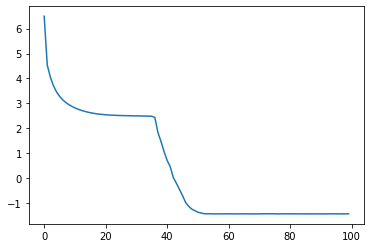

In [26]:
plt.plot(save_loss)
plt.show()

In [ ]:
plt.plot(lloss[0])
plt.show()

In [ ]:
model.lower

In [ ]:
model.upper

In [ ]:
model.mu

In [ ]:
currentAxis = plt.gca()
low = model.lower.numpy()[0]
upper = model.upper.numpy()[0]
currentAxis.add_patch(Rectangle((low[0], low[1]), upper[0]-low[0], upper[1]-low[1], fill=None,
                                    edgecolor='violet', alpha=1))
plt.scatter(X_train[:,0], X_train[:,1], color=[color_map[i] for i in y_train])
low = model.lower.numpy()[1]
upper = model.upper.numpy()[1]
currentAxis.add_patch(Rectangle((low[0], low[1]), upper[0]-low[0], upper[1]-low[1], fill=None, 
                                 edgecolor='green', alpha=1))
plt.scatter(*model.mu.numpy().T, marker='^')
plt.show()

In [ ]:
class testModel(tf.Module):

    def __init__(self, number_components):
        
        super(testModel, self).__init__()
        
        self.eta =  tf.Variable(0., trainable=False) 
        self.var = tf.Variable(1.0, dtype = tf.float32)
        self.var2 = tf.Variable(3.0, dtype = tf.float32)
        self.initialise_variables()
        self.M = 2
        
    @tf.function
    def initialise_variables(self):
        self.var.assign(2.0)
                              
    @tf.function
    def normalizing_constant(self, way = "independent"):
        dict1 = {(i,j): tf.square(self.var)
                 for j in range(1) for i in range(2)}
        
        return tf.reduce_sum(tf.stack([[dict1[(i,j)] for j in range(1)] for i in range(2)]))
        
    @tf.function
    def logistic (self, x):

        return tf.sigmoid(tf.math.multiply(self.eta,x))
        
    @tf.function
    def __call__(self, x):
        

        return tfd.Normal(loc = self.var, scale = self.var2).cdf(x)

    
model = testModel(2)
print(model.trainable_variables)


optimizer = tf.optimizers.Adam(lr = 0.001)

loss = 0.0
print(model.normalizing_constant())
@tf.function
def train_step(x):
    with tf.GradientTape() as tape:
        current_loss = model(x)
    gradients = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    
    return current_loss, gradients



lloss= {}
        
for i in range(1):

    #Maximization
    lloss[i] = []
    eta = (1./2) * i + 20
    for j in range(1):
        
        loss, grad = train_step(0)
        #print(model.trainable_variables)
        #print(grad)
        loss = loss.numpy() 
        lloss[i].append(loss)
        print(grad, model.trainable_variables)
    save_loss.append(loss)

In [ ]:
tfd.Normal(loc = 2.0, scale = 3.0).prob(0)

In [ ]:
model.normalizing_constant()